# PDS2: Final exam

### Date: June 18

### Time: 10:00 - 13:00


**Instructions:** 
* All answers should be filled in the notebook and then submitted to Moodle;
* For theoretical question you can use markdown and LaTeX;
* Save number of cells used for compilation;
* In order to get max scores, please write explanations and comments for each step. In addition, try to comment your code pieces.
* **Plagiarism will result in FAIL. For example, two students having identical code for solution, then both will get 0 mark for the exam.**


GOOD LUCK!

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Task 1 - Classification (25%)

Steps to do:

0. Read data from task_1_dataset.xlsx.
1. Find highly correlated features and remove one of them.
2. Split data into train and test (test size is 0.3).
3. Apply some feature selection technique.
4. Fit train dataset with several models of your choice (at least 3 different algorithms).
5. Think which models and what hyperparemeters should be tuned. Tune appropriate model with GridSearchCV or RandomSearchCV. Tune at least 2 hyperparameters.
6. Find AUC for train and test sets for all three models. Save results in data frame format. Show results.
7. Write some conclusion about model performances

In [14]:
#read excel file
df = pd.read_excel('task_1_dataset.xlsx')

#correlation matrix
corr_matrix = df.corr().abs()
#upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
#features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print('The highly correlated columns(above 95% of correlation) are:')
print(to_drop)
#drop 'var21' feature 
df.drop(to_drop[0], axis=1, inplace=True)
print(to_drop[0] + ' feature was removed')

The highly correlated columns(above 95% of correlation) are:
['var21', 'var22', 'var29']
var21 feature was removed


In [15]:
#splitting into train and test sets
y = df['target']
X = df.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#using SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
#selecting 5 best features
test = SelectKBest(score_func=f_classif, k=5)
fit = test.fit(X_train, y_train)
np.set_printoptions(precision=3)
print(fit.scores_)
print()

#using RFE
from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(logreg, 5)
fit = rfe.fit(X_train, y_train)
print('Features selected: ', fit.support_)
print("Features' Ranking: ", fit.ranking_)

[2.024e+02 1.925e+02 2.152e+02 1.692e+00 2.031e+00 2.162e+02 1.661e+00
 7.925e-01 1.371e-01 1.679e+02 3.229e-05 1.806e+02 1.923e+02 2.168e+02
 2.186e+02 2.118e+02 7.284e+02 1.874e+02 2.439e+00 1.842e-01 2.024e+02
 1.242e-01 1.618e+00 3.326e-01 2.178e+02 1.847e+02 2.151e+02 2.439e+00
 2.353e+02]

Features selected:  [False False  True False False False False False False False False False
 False  True False False  True False False False False False False False
 False False  True False  True]
Features' Ranking:  [18 15  1  8 11 10 16 23 24  4 14  7  5  1  9 25  1  2 19 17 12 20 21 13
  3  6  1 22  1]


In [23]:
#df updated: with selected fetures
X_train = X_train[['var3', 'var14', 'var17', 'var28', 'var30']]
X_test = X_test[['var3', 'var14', 'var17', 'var28', 'var30']]
#fitting Logistic Regression
logreg.fit(X_train, y_train)
pred_1 = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, pred_1))

#fitting RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_2 = rfc.predict(X_test)
print(metrics.accuracy_score(y_test, pred_2))

#fitting AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(X_train,y_train)
pred_3 = abc.predict(X_test)
print(metrics.accuracy_score(y_test, pred_3))

0.7133333333333334
0.7346666666666667
0.713


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
#defining and setting grid search for Logistic Regression
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
#best result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.714333 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}


In [30]:
#defining and setting grid search for RFC
grid = {
    'min_samples_leaf': [3, 4, 5],
    'n_estimators': [10, 50, 100] }
grid_search = GridSearchCV(estimator=rfc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
#best result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.747381 using {'min_samples_leaf': 5, 'n_estimators': 100}


In [29]:
#defining and setting grid search for ABC
grid = {
    "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 1.0],
    "n_estimators": [10, 50, 100, 500] }
grid_search = GridSearchCV(estimator=abc, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
#best result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.720810 using {'learning_rate': 0.1, 'n_estimators': 100}


In [31]:
#list for saving results:
ml = []
aucl = []
#Tuned LogReg:
logreg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
logreg.fit(X_train, y_train)
pred_1 = logreg.predict(X_test)
auc1 = metrics.roc_auc_score(y_test, pred_1) 
print(auc1)
ml.append('LogReg')
aucl.append(auc1)

#fitting RandomForestClassifier
rfc = RandomForestClassifier(min_samples_leaf=5, n_estimators=100)
rfc.fit(X_train, y_train)
pred_2 = rfc.predict(X_test)
auc2 = metrics.roc_auc_score(y_test, pred_2) 
print(auc2)
ml.append('RFC')
aucl.append(auc2)

#fitting AdaBoostClassifier
abc = AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
abc.fit(X_train,y_train)
pred_3 = abc.predict(X_test)
auc3 = metrics.roc_auc_score(y_test, pred_3) 
print(auc3)
ml.append('ABC')
aucl.append(auc3)

0.7133437393332576
0.7403110422118557
0.7243269285470475


In [32]:
dict = {'model': ml, 'auc': aucl} 
results = pd.DataFrame(dict)
results 

,model,auc
0,LogReg,0.713344
1,RFC,0.740311
2,ABC,0.724327


So, after tuning we this results above, with best performance on the RFC

## Task 2 - Clustering (25%)

Steps to do:

0. Read data from task_2_dataset.xlsx.
1. Fit KMEans 8 times with values of K from 1 to 8.
2. Save square root of _inertia__ attribute into list and plot those values with corresponding K's.
3. Using 'elbow' rule, find out how many clusters we have in our dataset.
4. Create KMeans with selected values of K from the previous step.
5. Save labels for each observation into _labels_ array.
6. Apply PCA to reduce dimension of your data, use n_components as 2.
7. Plot scatterplot of 2 components with different colors from _labels_ array.
8. Comment your findings.

In [57]:
df = pd.read_excel('task_2_dataset.xlsx')
df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,-0.501163,-7.255475,-5.572167,-1.805756,-1.591788,7.309525,-6.865964,0.689374,1.059544,-9.284560
1,2.129898,-6.030686,-4.523330,-3.016737,-1.476348,4.291699,-6.780570,0.334200,2.054573,-9.941892
2,-2.173184,9.295427,5.713340,0.841088,-6.221385,-6.348730,-8.966260,7.628342,2.948812,4.946535
3,-9.149524,9.426631,6.372079,-5.774996,-5.671090,-6.380030,-4.059996,0.283833,-2.255232,-3.239336
4,3.177287,-5.794053,-3.438450,-0.885736,-0.407087,4.826428,-7.255387,-0.543231,1.440112,-9.680664


In [58]:
from sklearn.cluster import KMeans
    
km = KMeans()
#km.fit()

## Task 3 - Regression (25%)

Steps to do:

0. Read data from task_3_dataset.xlsx.
1. Check basic info about dataset.
2. Perform some EDA with visualisation.
3. Split data into train and test (test size 0.3).
4. Fit a linear regression model.
5. Find $R^2$ on train and test datasets. Save results into dataframe.
6. Plot scatterplot of actual target vs. predicted on test dataset.
7. Fit any regularized linear regression model.
8. Using CV find optimal alpha.
9. For model with optimal alpha find $R^2$ on train and test datasets. Save results into dataframe.
10. Compare performance of the models. Write some conclusions.

In [33]:
df = pd.read_excel('task_3_dataset.xlsx')
df

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,...,var42,var43,var44,var45,var46,var47,var48,var49,var50,target
0,-0.552089,-1.145582,-0.931693,0.714074,1.535745,0.267954,0.541724,1.532839,0.731628,-0.455638,...,-0.681037,0.391393,-0.143473,-0.383202,0.699552,-0.590929,-0.698003,0.269960,1.695117,84.079638
1,-0.045569,-0.649839,0.112068,-0.311601,1.080510,0.994413,-0.210373,-1.681002,1.154218,1.136129,...,1.442451,0.250696,0.552947,-1.188570,-0.777756,-0.565737,1.722244,-0.461826,0.587752,30.657333
2,-0.986841,0.231556,-0.657143,-1.008164,-0.471398,-1.404933,-0.509124,0.925725,0.049995,1.393613,...,0.932760,-1.479063,0.678840,-1.538005,-0.267960,0.648383,1.317819,0.606854,-0.061530,-334.801479
3,-1.336637,-1.189614,0.763404,-0.963962,1.130956,-0.932618,2.108902,0.215339,0.296754,-1.063522,...,0.791164,-0.510876,-0.054669,1.499147,0.734234,1.570248,1.914833,-0.974446,-1.786229,-284.953354
4,-0.523307,-1.293480,-0.084331,0.596403,-1.643833,-0.796517,1.719972,-0.548076,0.531256,-0.482633,...,-1.591038,0.577650,0.058708,0.507060,0.280299,1.427768,-0.343348,-0.724645,1.119481,89.542225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.455621,0.809148,0.136774,1.042978,2.544667,-0.117241,2.076347,2.338134,-1.742637,-0.492393,...,-0.365453,-3.020437,-0.733538,0.363486,0.273898,0.694562,0.523987,0.014478,0.291321,85.859576
9996,0.339319,0.218574,2.858770,2.567616,-1.847862,-1.068002,0.390997,-0.490075,1.436485,0.636227,...,-1.566009,1.111764,0.552715,1.192595,0.135034,1.323441,-1.260966,-0.300502,0.370411,66.636372
9997,-1.404336,-0.297380,-0.301699,-0.222700,0.309756,-0.094808,-1.538507,0.797915,-1.532157,-0.310467,...,-0.370511,-3.194777,0.796596,0.761567,0.002736,-1.251226,0.011071,-0.843815,0.094374,-381.836254
9998,-0.065574,-2.818906,-3.176212,-1.381020,-1.488167,0.268837,0.677552,-0.924242,0.632594,0.459018,...,0.487727,0.339936,-0.188471,-2.334377,0.996953,1.975468,1.695082,-0.329155,-0.161570,142.185777


In [36]:
print(df.info())
print('EDA')
print('Unique values target column')
print(df.target.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   var1    10000 non-null  float64
 1   var2    10000 non-null  float64
 2   var3    10000 non-null  float64
 3   var4    10000 non-null  float64
 4   var5    10000 non-null  float64
 5   var6    10000 non-null  float64
 6   var7    10000 non-null  float64
 7   var8    10000 non-null  float64
 8   var9    10000 non-null  float64
 9   var10   10000 non-null  float64
 10  var11   10000 non-null  float64
 11  var12   10000 non-null  float64
 12  var13   10000 non-null  float64
 13  var14   10000 non-null  float64
 14  var15   10000 non-null  float64
 15  var16   10000 non-null  float64
 16  var17   10000 non-null  float64
 17  var18   10000 non-null  float64
 18  var19   10000 non-null  float64
 19  var20   10000 non-null  float64
 20  var21   10000 non-null  float64
 21  var22   10000 non-null  float64
 22 

<AxesSubplot:>

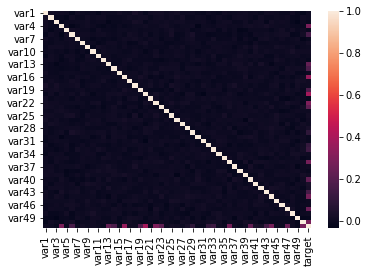

In [37]:
cor = df.corr()

sns.heatmap(cor)

<AxesSubplot:xlabel='target', ylabel='Density'>

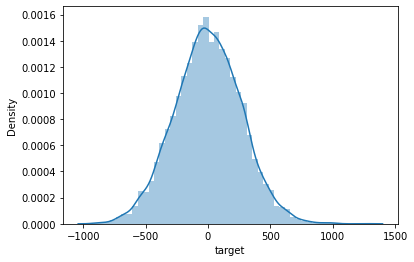

In [39]:
sns.distplot(df['target'])

In [43]:
from sklearn.linear_model import LinearRegression

y = df['target']
X = df.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_1 = linreg.predict(X_test)
tl = []
sl = []

r2_1 = metrics.r2_score(y_test, y_pred_1)
tl.append('test')
sl.append(r2_1)

y_pred_2 = linreg.predict(X_train)
r2_2 = metrics.r2_score(y_train, y_pred_2)
tl.append('train')
sl.append(r2_1)

dict = {'set': tl, 'score': sl} 
results = pd.DataFrame(dict)
results 

,set,score
0,test,1.0
1,train,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

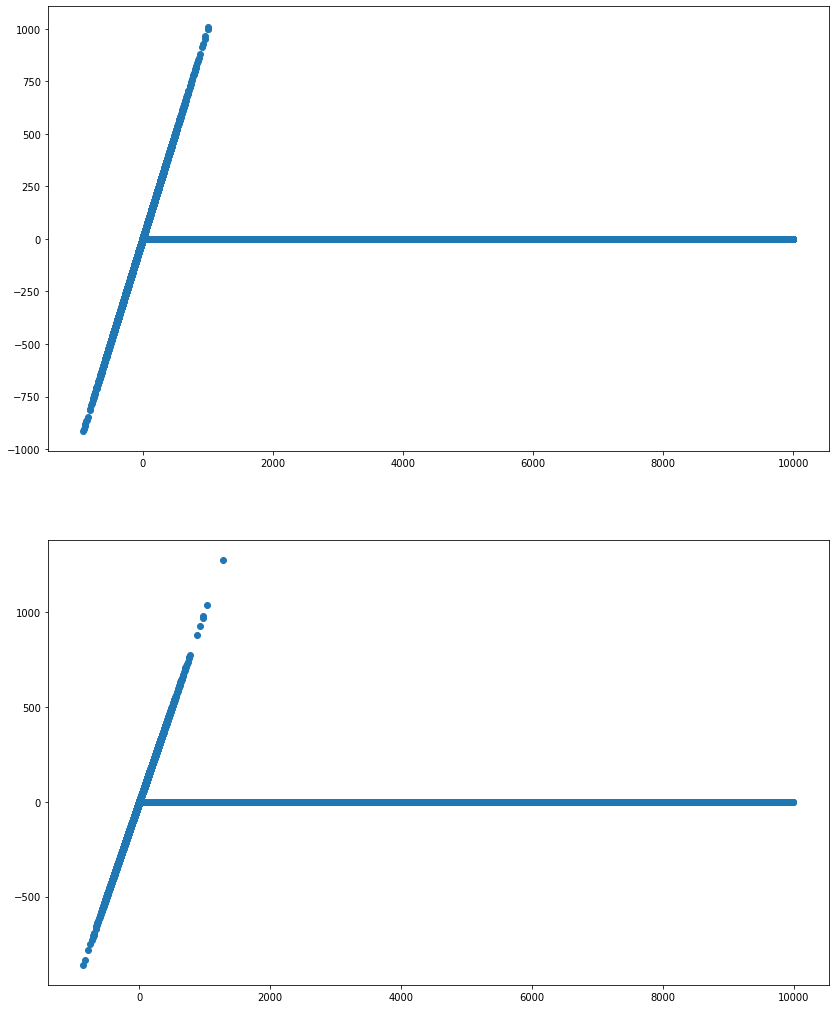

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(14, 18))
ax[0].scatter(y_train, y_pred_2)
ax[0].plot(y_train-y_pred_2,marker='o',linestyle='')

ax[1].scatter(y_test, y_pred_1)
ax[1].plot(y_test-y_pred_1,marker='o',linestyle='')
plt.show

In [56]:
from sklearn.linear_model import Ridge, RidgeCV

alphas = [0.001, 0.1, 1, 10]

rcv = RidgeCV(alphas=alphas, cv=5)

rcv.fit(X_train, y_train)
y_pred = rcv.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print('MSE: ', mse)

MSE:  1.3850484522342992e-09


## Task 4 - Theory (25%)
Choose any 3 questions and on your own words answer to them:
1. What is the difference between KNN and K-means models? Explain each model briefly. (5%)
2. Explain advantage of using Random Forest model over Decision Tree model. (5%)
3. Describe how regularized linear regression models work. (5%)
4. Explain Bias-Variance Tradeoff principle. (5%)
5. What metrics you would use in case of imbalanced dataset in classification problem? Explain each metrics and why you would use it. (5%).

1.  K-Means is a clustering algorithm that tries to segment a set of points into K sets such that the points in each cluster tend to be close each other. It is unsupervised because the points have no external classification. 

    KNN is a classification algo that's used to determine the classification of a point, combines the classification of the K nearest points. It is supervised as you're trying to classify a point based on the known classification of other points.
    
2. Random forests are a strong modeling method and much more strong than a single decision tree, as they aggregate a lot of choice trees to limit overfitting as well as error due to bias and thus yield better results.

3. This regression form regularizes the coefficent to 0, moreover, it damps more complexity or flexibily of a model for avoiding the risk of overfitting.

4. It is the property of a model that the variance of the parameter estimates across samples can be reduced by increasing the bias in the estimated parameters, exactly, variance is an error from sensitivity to small fluctuations in the training set.

5. 
    1. F1 metric is the harmonic average of the precision and recall and calculated as:
        F1 = 2TP/(2TP+FP+FN)
    2. Precision metric shows how many predicted samples are relevant:
        Prec = TP/(TP+FP)
    3. ROC-AUC for bin. class.:
        auc = (tpr+tnr)/2

---

### Evaluation form (Keep it)

| Question | Mark  | Comennt   
|:-------:|:--------:|:----------------------
| 1       |   25/25    | 
| 2       |   25/25    | 
| 3       |   25/25    | 
| 4       |   25/25    | 

|**Total**|**100/100**  | 
